<a href="https://colab.research.google.com/github/uliang/MS9002-Data-mining-techniques/blob/master/k_Nearest_Neighbours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*MS9002: Data Mining Techniques* 

###Python Lab session 2: Understanding the $k$ nearest neighbours algorithm


---



In this lab session, we will investigate how to tune the value of $k$ in the nearest neighbours algorithm using a simple cross validation procedure. 

*Learning objectives* 

- To analyze the effect of rescaling on the accuracy of prediction with a nearest neighbour algorithm. 
-  To study the effect of changing the parameter $k$ on the accuracy of a nearest neighbour 
classifier. 

### Dataset description 

In [4]:

from sklearn.datasets import load_breast_cancer
import seaborn as sns
import pandas as pd
import numpy as np

dataset = load_breast_cancer()

## we create this dataframe for visualization and data analysis. 

df = pd.DataFrame(np.c_[dataset['data'], dataset['target']],
                  columns=list(dataset['feature_names'])+['target'])\
      .replace({'target': {1: 'benign', 0: 'malignant'}})
  
print(dataset['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [0]:
## Splitting the dataset into 80:20 training instances and 
## testing instances. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset['data'], dataset['target'], test_size=0.2, random_state=1)



We are able to visualize the distribution of labels in this multi dimensional dataset using a technique known as PCA. As always, data observation and visual analysis is only performed on the training set. 

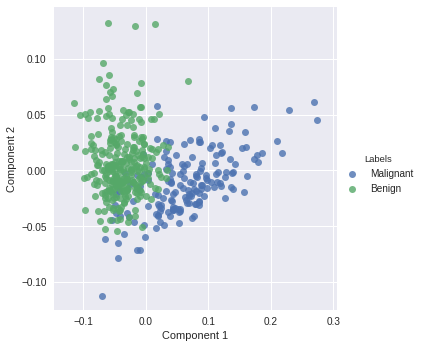

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

visual_pipeline = make_pipeline(Normalizer(), PCA(n_components=2))

X_reduced = visual_pipeline.fit_transform(X_train)
pd.DataFrame(np.c_[X_reduced, y_train],
             columns=['Component 1', 'Component 2', 'Labels'])\
  .replace({'Labels': {0: 'Malignant', 1:'Benign'}})\
  .pipe((sns.lmplot, 'data'),
        x='Component 1', y='Component 2', hue='Labels', fit_reg=False)

**Discussion** 

1. What do you notice about the distribution of data points with respect to the labels? 




2. Would you be optimistic about constructing a data mining model? Why or why not? 



---

### Modelling

Let us build a k-nearest neighbours model and evaluate it's performance. 

In [0]:
#@title Set the number of nearest neighbours
k = 3 #@param {type:"integer"}



In [37]:
from sklearn.neighbors import KNeighborsClassifier


## Validation step 
if not k > 0: 
  raise ValueError('Value of k must be positive')
  

## For apples to apples comparison with automated hyperparameter tuning. 
## We further reduce down the training set and set aside a portion 
## as a validation set 

X_rtrain, X_valid, y_rtrain, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)


## Building a model. We need to normalize the data before
## passing it to the fitted. 
knn_model = make_pipeline(Normalizer(), KNeighborsClassifier(n_neighbors=k))
knn_model.fit(X_rtrain, y_rtain)
training_score = knn_model.score(X_rtrain, y_rtrain) 
validation_score = knn_model.score(X_valid, y_valid) 

## output 
print(f'Number of neighbors: {k}')
print(f'Training score: {training_score:.4f}')
print(f'Validation score: {validation_score:.4f}')

Number of neighbors: 22
Training score: 0.9326
Validation score: 0.9123


__Task__

Train the model with different values of  $k$ and observe how the training and validation score changes. Based on the returned scores, how many nearest neighbours would you consider optimal for your model? 

__Discussion__

1. If $k$ is set equal to the entire size of `X_rtrain`, what in effect is the model doing? 

We can loop over a range of values of $k$ and chart the scores of the model for each value of $k$. 

In [0]:
## Uncomment this section and run the cell to see the output


##scores = [] 
##for n_neighbors in range(1, 51): 
##  knn_model.set_params(kneighborsclassifier__n_neighbors=n_neighbors)
##  knn_model.fit(X_rtrain, y_rtrain)
##  scores.append((knn_model.score(X_rtrain, y_rtrain),
##                 knn_model.score(X_valid, y_valid)))
  


##pd.DataFrame(np.c_[np.arange(1,51), np.array(scores)],
##             columns=['k', 'Training', 'Validation'])\
##  .plot(kind='line', x='k')

__Discussion__ 

1. Comment on the behaviour of the model as we increase the values of $k$. Discuss the nature of variability in influencing the obtained scores

2. What are the engineering and statistical implications of choosing a value of $k$ which is too high? 

In [0]:
## We can use scikit learn's built in cross-validation procedure
## to optimize the hyperparameters of the nearest neighbors model. 

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_model, param_grid={
    'kneighborsclassifier__n_neighbors': np.arange(1, 51)
  }, cv=5, verbose=1, n_jobs=-1 )

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)

## ouputs

print('\n'*2)
print('Results\n','-'*100, sep='')
print(*list(grid_search.best_params_.items())[0])
print(f'The best cross validated score: {grid_search.best_score_:.4f}')
print(f'Score of the refit model on the testing set: {test_score:.4f}\n\n')

__Conclusion__

Cross validation helps reduce errors due to bias and variance and gives a more accurate evaluation of model performance. 